In [1]:
pip install livelossplot

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Conv2D, MaxPooling2D, Flatten
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tqdm import trange, notebook
from livelossplot import PlotLossesKeras



In [3]:
data_path = 'D:/AI_Alignment/algorithm_data'

In [6]:
def load_data(data_path, num_samples):
    wavefront_maps = []
    errors = []


    for i in range(1, num_samples + 1):
        folder_path = os.path.join(data_path, f'data{i}')
        wfm_data = []

        for j in range(1, 6):
            file_path = os.path.join(folder_path, f'wfm_{j}.txt')
            with open(file_path, 'r', encoding='utf-16') as f:
                lines = f.readlines()
                data = np.array([list(map(float, line.split())) for line in lines])
                wfm_data.append(data)
                
        wfm_data = np.array(wfm_data).reshape(5, 64, 64, 1)
        wavefront_maps.append(wfm_data)
        
        
        
        error_file_path = os.path.join(folder_path, 'error.txt')
        error_data = np.loadtxt(error_file_path)
        errors.append(error_data)

        

    return np.array(wavefront_maps), np.array(errors)

In [7]:
num_samples = 20000
X, y = load_data(data_path,num_samples)

In [8]:
len(y)

20000

In [33]:
X.shape

(20000, 5, 64, 64, 1)

In [9]:
indices=range(num_samples)

In [36]:
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, 64*64)
X_scaled = scaler.fit_transform(X_reshaped).reshape(-1, 5, 64, 64, 1)


In [69]:
X_scaled[2][3][4][30]

array([0.68048366])

In [70]:
X[2][3][4][30]

array([6.983954])

In [11]:
X_scaled.shape

(20000, 5, 64, 64, 1)

In [12]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, indices, test_size=0.2, random_state=42)

In [32]:
import joblib
joblib.dump(scaler,'MinMaxScaler.pkl')

['MinMaxScaler.pkl']

## 2DConv

In [15]:
cnn_model = Sequential([
    Conv2D(32,(1,1), activation='relu',input_shape=(5,64,64),data_format='channels_first'),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(6)
    ])

In [16]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 64, 64)     │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6720)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       860,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898,182 (3.43 MB)

 Trainable params: 898,182 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

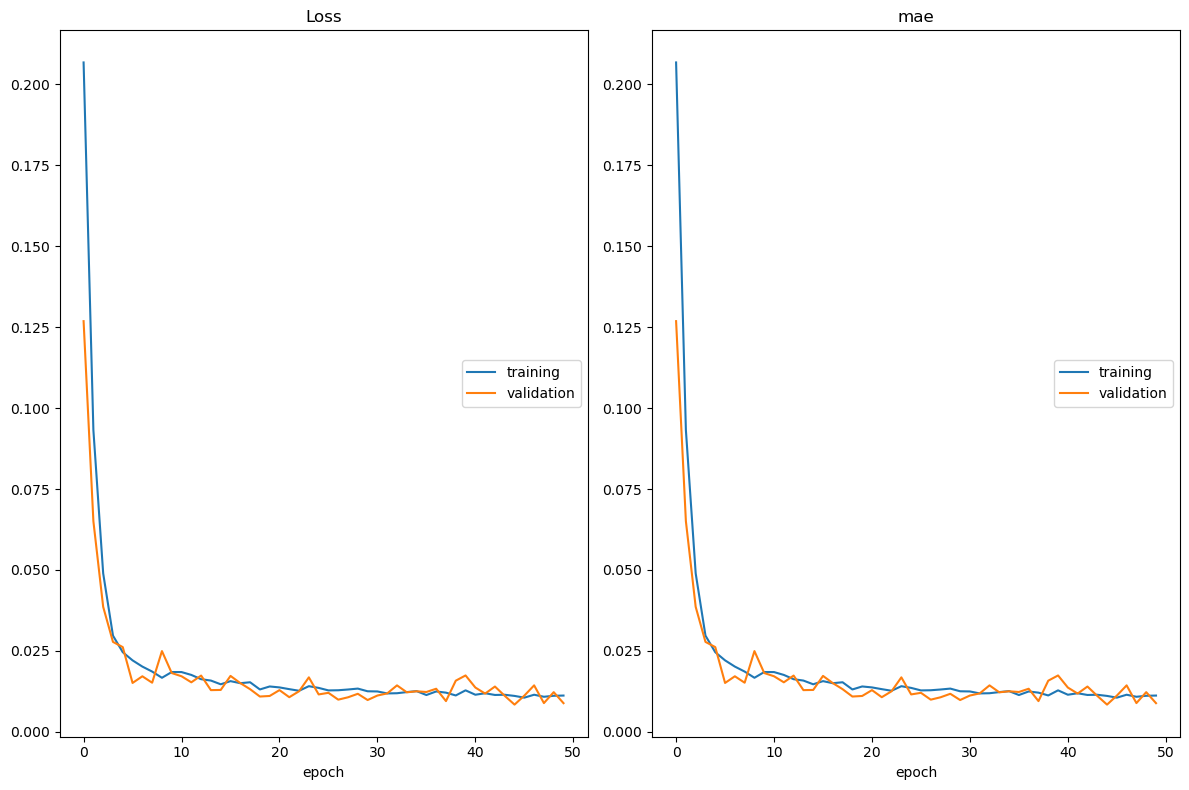

Loss
	training         	 (min:    0.011, max:    0.207, cur:    0.011)
	validation       	 (min:    0.008, max:    0.127, cur:    0.009)
mae
	training         	 (min:    0.011, max:    0.207, cur:    0.011)
	validation       	 (min:    0.008, max:    0.127, cur:    0.009)
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0116 - mae: 0.0116 - val_loss: 0.0089 - val_mae: 0.0089


In [17]:
cnn_model.compile(optimizer='adam', loss='mae', metrics=['mae'])
cnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [19]:
model_cnn_eval = cnn_model.evaluate(X_test, y_test)

print(f'Model MAE :{model_cnn_eval[1]}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0089
Model MAE :0.008974703960120678


In [20]:
model_predic = cnn_model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [31]:
from keras.models import load_model
import keras
keras.saving.save_model(cnn_model, 'cnn_2d.keras')

In [21]:
for i in range(5):
    print(f'Sample {i+1}:')
    print(f'Actual Errors: {y_test[i]}')
    print(f'Predicted Errors: {model_predic[i]}')
    print()

Sample 1:
Actual Errors: [-0.588 -0.411  0.063  0.457  0.183  0.008]
Predicted Errors: [-0.59139854 -0.42424095  0.06545163  0.46498415  0.18284486 -0.00636907]

Sample 2:
Actual Errors: [ 0.016  0.305  0.435  0.247 -0.104 -0.427]
Predicted Errors: [ 0.00854663  0.2916363   0.43864444  0.24644744 -0.10008821 -0.43695238]

Sample 3:
Actual Errors: [ 0.534  0.44   0.103  0.472 -0.062  0.462]
Predicted Errors: [ 0.532651    0.45075494  0.08780148  0.475982   -0.06641891  0.438626  ]

Sample 4:
Actual Errors: [-0.431  0.268  0.225 -0.478 -0.194 -0.492]
Predicted Errors: [-0.46196032  0.25883922  0.23346007 -0.485383   -0.20381069 -0.49279642]

Sample 5:
Actual Errors: [ 0.579 -0.359  0.436 -0.119  0.103  0.086]
Predicted Errors: [ 0.5794509  -0.34583804  0.43219846 -0.12231163  0.10226656  0.08019978]



## 결과저장

In [22]:
test_indices

[10650,
 2041,
 8668,
 1114,
 13902,
 11963,
 11072,
 3002,
 19771,
 8115,
 3525,
 7879,
 16441,
 16296,
 12566,
 5252,
 19393,
 16796,
 8094,
 322,
 9923,
 7459,
 19024,
 17553,
 9119,
 16421,
 16060,
 10120,
 19055,
 3649,
 3941,
 17880,
 16675,
 12630,
 11443,
 12157,
 13835,
 3434,
 18739,
 17407,
 15440,
 10406,
 6517,
 971,
 16487,
 19730,
 13137,
 3669,
 15983,
 4058,
 14976,
 15698,
 13829,
 13419,
 960,
 17744,
 9864,
 11263,
 15782,
 17196,
 7554,
 10498,
 17059,
 17928,
 7085,
 14753,
 4519,
 3024,
 12121,
 18494,
 5483,
 1419,
 6209,
 10742,
 16143,
 17617,
 14568,
 980,
 2783,
 7713,
 11518,
 8600,
 11640,
 18830,
 12562,
 12751,
 6384,
 4807,
 6195,
 10648,
 7567,
 16397,
 17524,
 1346,
 13124,
 12673,
 15455,
 14001,
 18621,
 2119,
 15304,
 4309,
 4484,
 11013,
 4770,
 2712,
 12186,
 16615,
 10947,
 2545,
 12619,
 9851,
 4410,
 19647,
 12344,
 12407,
 9610,
 10718,
 7571,
 3570,
 8602,
 3559,
 4991,
 7439,
 9325,
 2300,
 7666,
 5804,
 12022,
 15537,
 9757,
 12014,
 5211,

In [23]:
predicted_file_number = []
for i in range(len(test_indices)) :
    a = test_indices[i] + 1
    b = str(a)
    predicted_file_number.append(b)

In [24]:
predicted_file_number

['10651',
 '2042',
 '8669',
 '1115',
 '13903',
 '11964',
 '11073',
 '3003',
 '19772',
 '8116',
 '3526',
 '7880',
 '16442',
 '16297',
 '12567',
 '5253',
 '19394',
 '16797',
 '8095',
 '323',
 '9924',
 '7460',
 '19025',
 '17554',
 '9120',
 '16422',
 '16061',
 '10121',
 '19056',
 '3650',
 '3942',
 '17881',
 '16676',
 '12631',
 '11444',
 '12158',
 '13836',
 '3435',
 '18740',
 '17408',
 '15441',
 '10407',
 '6518',
 '972',
 '16488',
 '19731',
 '13138',
 '3670',
 '15984',
 '4059',
 '14977',
 '15699',
 '13830',
 '13420',
 '961',
 '17745',
 '9865',
 '11264',
 '15783',
 '17197',
 '7555',
 '10499',
 '17060',
 '17929',
 '7086',
 '14754',
 '4520',
 '3025',
 '12122',
 '18495',
 '5484',
 '1420',
 '6210',
 '10743',
 '16144',
 '17618',
 '14569',
 '981',
 '2784',
 '7714',
 '11519',
 '8601',
 '11641',
 '18831',
 '12563',
 '12752',
 '6385',
 '4808',
 '6196',
 '10649',
 '7568',
 '16398',
 '17525',
 '1347',
 '13125',
 '12674',
 '15456',
 '14002',
 '18622',
 '2120',
 '15305',
 '4310',
 '4485',
 '11014',
 '477

In [26]:
with open('D:/AI_Alignment/algorithm_data/predicted_file_number.txt','w') as file :
    for i in predicted_file_number :
        file.write(i+'\n')


In [27]:
a = list(model_predic[0])
a

[-0.59139854, -0.42424095, 0.06545163, 0.46498415, 0.18284486, -0.006369069]

In [28]:
for i in range(len(predicted_file_number)) :
    file_path = 'D:/AI_Alignment/algorithm_data/data' + predicted_file_number[i] + '/predicted_error.txt'
    error = list(model_predic[i])
    with open(file_path,'w') as f :
        for item in error :
            f.write(str(item) + '\n')